## Import Dependencies

In [1]:
# Import Dependencies
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Define Image Data Transform

In [2]:
# Define the image transform
# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

## Load Training and Test Data

In [3]:
# Load Training Data
train_data = torchvision.datasets.CIFAR10(root='./cifar_data/', train=True, download=True, transform=transform)

# Load Test Data
test_data = torchvision.datasets.CIFAR10(root='./cifar_data/', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


## Create Training and Test Data Loader

In [4]:
# Create Train Data Loader
trainLoader = torch.utils.data.DataLoader(train_data, batch_size=5, shuffle=True, num_workers=3)

# Create Test Data Loader
testLoader = torch.utils.data.DataLoader(test_data, batch_size=5, shuffle=False, num_workers=3)

## Define Class labels for further use

In [5]:
# Define Class Labels
class_labels = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Plot Sample Images from Dataset

In [6]:
# Function to show sample images
def show_image(image=None, label=None):
    labels = []
    plt.figure(figsize=(20,10))
    # Un-normalize the Image
    image = image/2 + 0.5
    # Convert Image to Numpy for plotting
    np_img = image.numpy()
    plt.imshow(np.transpose(np_img, (1,2,0)))
    
    l = label.numpy()
    
    for i in l:
        labels.append(class_labels[i])
        
    plt.title("Labels: " + str(labels))

In [7]:
# Get some random images from training set
dataIter = iter(trainLoader)
img, labels = dataIter.next()

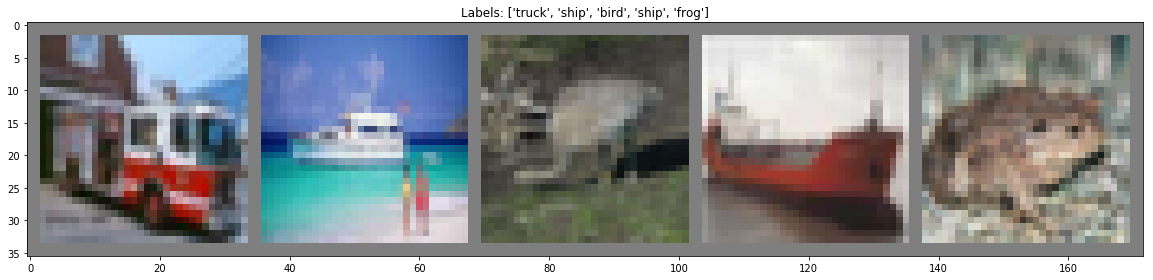

In [8]:
# Show Images
show_image(image=torchvision.utils.make_grid(img), label=labels)

## Define a Convolutional Neural Network

In [9]:
# Import Dependencies
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [10]:
# CNN Model class
class CNNModel(nn.Module):
    # Initialize all Layers
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
# Initialize the Model
cnn = CNNModel()

In [12]:
# Define Loss Function
loss_criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

## Train the Network

In [13]:
epochs = 3

for epoch in range(epochs):
    running_loss = 0.0
    
    for i, data in enumerate(trainLoader, 0):
        # Load Images and Labels in Batches
        images, labels = data
        
        # Zero the Optimizer Gradient Values
        optimizer.zero_grad()
        
        # Define Model output
        y_hat = cnn(images)
        
        # Define Loss
        loss = loss_criterion(y_hat, labels)
        
        # Do backward Propagation of gradients
        loss.backward()
        
        # Take one step for optimizer
        optimizer.step()
        
        # Capture Loss
        running_loss += loss.item()
        
        # Print Loss and Accuracy
        if i%2000 == 1999:
            print("Epoch: {0}\t i: {1}\t Loss: {2}".format(epoch+1, i+1, running_loss/2000))
            # Reset Running Loss
            running_loss = 0.0

print("\nFinished Training...")

Epoch: 1	 i: 2000	 Loss: 1.8343812523782252
Epoch: 1	 i: 4000	 Loss: 1.552497156277299
Epoch: 1	 i: 6000	 Loss: 1.4457302920371293
Epoch: 1	 i: 8000	 Loss: 1.4124322621151806
Epoch: 1	 i: 10000	 Loss: 1.3608716068193316
Epoch: 2	 i: 2000	 Loss: 1.2771225582435728
Epoch: 2	 i: 4000	 Loss: 1.2644084264487028
Epoch: 2	 i: 6000	 Loss: 1.2526400725096465
Epoch: 2	 i: 8000	 Loss: 1.2414843060672283
Epoch: 2	 i: 10000	 Loss: 1.2116613011285662
Epoch: 3	 i: 2000	 Loss: 1.1488727328665556
Epoch: 3	 i: 4000	 Loss: 1.1544695878177882
Epoch: 3	 i: 6000	 Loss: 1.1664792434200644
Epoch: 3	 i: 8000	 Loss: 1.1473809243068098
Epoch: 3	 i: 10000	 Loss: 1.1287699852846562

Finished Training...


## Plot Sample Test Data

In [14]:
# Get a batch of data from test set
dataIter = iter(testLoader)
images, labels = dataIter.next()

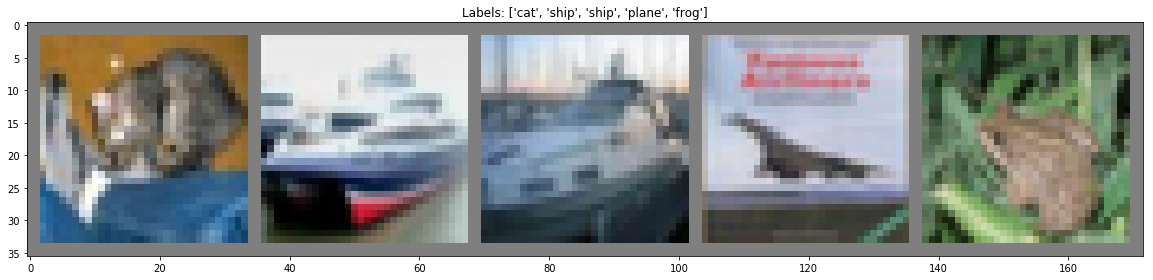

In [15]:
# Show Images
show_image(image=torchvision.utils.make_grid(images), label=labels)

## Make Predictions on the above Images using Trained Model

In [16]:
y_out = cnn(images)
_, y_pred = torch.max(y_out, 1)

# Predicted Labels
y_pred = y_pred.numpy()
pred_labels = []
for i in y_pred:
    pred_labels.append(class_labels[i])
print("Predicted Labels: {}".format(pred_labels))

Predicted Labels: ['cat', 'ship', 'plane', 'plane', 'bird']


## Make Predictions on Whole Test Data

In [17]:
# Num Correct Labels
num_correct = 0

# Total Predictions
total = 0

# We don't need to backpropagate or find gradients, so turn it Off
with torch.no_grad():
    for data in testLoader:
        # Get test images and labels in batches
        images, labels = data
        # Get Model prediction on images
        y_out = cnn(images)
        # Get max probb value for each prediction made
        _, y_pred = torch.max(y_out, 1)
        # total number of Labels in test set
        total += labels.size(0)
        # Number of correct predictions
        num_correct += (y_pred == labels).sum().item()
print("Model Accuracy on Test Data: {}".format(100*num_correct/total))

Model Accuracy on Test Data: 59.08


## Which classes Perfomed Well and Which did not

In [18]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testLoader:
        images, labels = data
        y_out = cnn(images)
        _, y_pred = torch.max(y_out, 1)
        c = (y_pred == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (class_labels[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 61 %
Accuracy of   car : 73 %
Accuracy of  bird : 54 %
Accuracy of   cat : 32 %
Accuracy of  deer : 43 %
Accuracy of   dog : 45 %
Accuracy of  frog : 76 %
Accuracy of horse : 64 %
Accuracy of  ship : 65 %
Accuracy of truck : 72 %
